<a href="https://colab.research.google.com/github/bhanupra7ap/Fundamental_analysis/blob/main/fundamental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd

In [ ]:
def get_post_ipo_data(ticker, start_date, end_date):

    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)

    # Check if data is returned
    if stock_data.empty:
        print(f"No data found for {ticker}")
        return None

    # Return stock data
    return stock_data

In [ ]:
ipo_companies = {
    'GOOGL': '2004-08-19',  # Google IPO date
    'FB': '2012-05-18',     # Facebook IPO date
    'UBER': '2019-05-10'    # Uber IPO date
}

# Collect data for a period after the IPO (e.g., 6 months post IPO)
post_ipo_duration = '6mo'  # You can adjust this to '3mo', '1yr', etc.

In [ ]:
ipo_data = {}

# Fetch post-IPO stock data for each company
for ticker, ipo_date in ipo_companies.items():
    print(f"Fetching data for {ticker} post-IPO")

    # Convert IPO date to end date for fetching post-IPO data
    stock_data = get_post_ipo_data(ticker, start_date=ipo_date, end_date=None)

    # If data is available, save it
    if stock_data is not None:
        ipo_data[ticker] = stock_data

Fetching data for GOOGL post-IPO


ERROR:yfinance:$FB: possibly delisted; no timezone found


Fetching data for FB post-IPO
No data found for FB
Fetching data for UBER post-IPO


In [ ]:
for ticker, data in ipo_data.items():
    print(f"\nStock data for {ticker}:\n")
    print(data.head())


Stock data for GOOGL:

                               Open      High       Low     Close     Volume  \
Date                                                                           
2004-08-19 00:00:00-04:00  2.496321  2.597672  2.395469  2.504808  893181924   
2004-08-20 00:00:00-04:00  2.521534  2.722988  2.508803  2.703765  456686856   
2004-08-23 00:00:00-04:00  2.764676  2.832825  2.722238  2.730976  365122512   
2004-08-24 00:00:00-04:00  2.776908  2.785895  2.585440  2.617892  304946748   
2004-08-25 00:00:00-04:00  2.620139  2.696027  2.593179  2.646101  183772044   

                           Dividends  Stock Splits  
Date                                                
2004-08-19 00:00:00-04:00        0.0           0.0  
2004-08-20 00:00:00-04:00        0.0           0.0  
2004-08-23 00:00:00-04:00        0.0           0.0  
2004-08-24 00:00:00-04:00        0.0           0.0  
2004-08-25 00:00:00-04:00        0.0           0.0  

Stock data for UBER:

                     

In [ ]:
for ticker, data in ipo_data.items():
    data.to_csv(f"{ticker}_post_ipo_data.csv")
    print(f"Saved {ticker} data to CSV")

Saved GOOGL data to CSV
Saved UBER data to CSV


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Replace 'GOOGL_post_ipo_data.csv' with your CSV file name
df = pd.read_csv('GOOGL_post_ipo_data.csv')

# Display the first few rows
print(df.head())

                        Date      Open      High       Low     Close  \
0  2004-08-19 00:00:00-04:00  2.496321  2.597672  2.395469  2.504808   
1  2004-08-20 00:00:00-04:00  2.521534  2.722988  2.508803  2.703765   
2  2004-08-23 00:00:00-04:00  2.764676  2.832825  2.722238  2.730976   
3  2004-08-24 00:00:00-04:00  2.776908  2.785895  2.585440  2.617892   
4  2004-08-25 00:00:00-04:00  2.620139  2.696027  2.593179  2.646101   

      Volume  Dividends  Stock Splits  
0  893181924        0.0           0.0  
1  456686856        0.0           0.0  
2  365122512        0.0           0.0  
3  304946748        0.0           0.0  
4  183772044        0.0           0.0  


In [ ]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop unnecessary columns if present
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True, errors='ignore')

# Check for missing values
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


<ipython-input-47-631f0a6da91b>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
# Create lag features (e.g., previous day's closing price)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)

# Drop rows with NaN values resulting from lag features
df.dropna(inplace=True)

In [ ]:
# Features: All columns except 'Close'
X = df.drop('Close', axis=1)

# Target variable: 'Close' price
y = df['Close']

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


In [ ]:
best_xgb_model = grid_search.best_estimator_

In [ ]:
# Predict on test data
y_pred = best_xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

Root Mean Squared Error (RMSE): 49.52
R-squared (R²): -2.7972


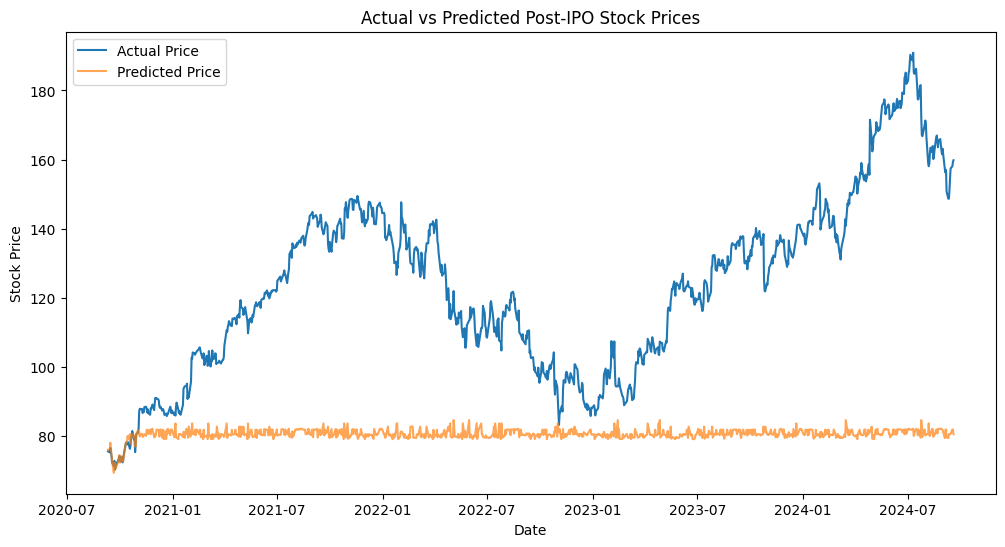

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Post-IPO Stock Prices')
plt.legend()
plt.show()

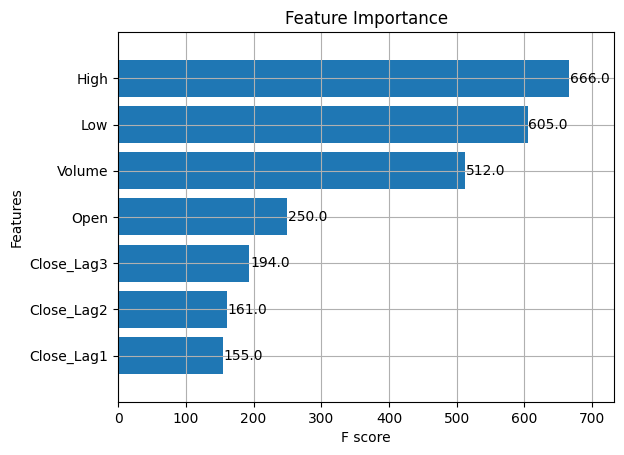

In [ ]:
# Plot feature importance
xgb.plot_importance(xgb_model, height=0.8)
plt.title('Feature Importance')
plt.show()